<a href="https://www.kaggle.com/code/tbillington/sql-analysis-of-us-craft-beers-breweries?scriptVersionId=163102705" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

![](https://www.oculyze.net/wp-content/uploads/2023/02/how-to-clean-beer-taps-2.jpg)

# US Craft Beers

In [1]:
import pandas as pd
import seaborn as sns
sns.set_palette("dark")
import matplotlib.pyplot as plt
import sqlite3

conn = sqlite3.connect("/kaggle/input/beer-and-breweries-db/beers.db")

In [2]:
df = pd.read_sql_query("""
SELECT name 
FROM sqlite_master 
WHERE type = 'table';
""", conn)

df

,name
0,beers
1,breweries


In [3]:
# Finding the column names and types in each table:

for table in ['beers','breweries']:
    
    df = pd.read_sql_query(f"""
    PRAGMA table_info({table});
    """, conn)
    print(df[['name','type']])
    print('='*30)

         name     type
0         abv     REAL
1         ibu     REAL
2          id  INTEGER
3        name     TEXT
4       style     TEXT
5  brewery_id  INTEGER
6      ounces     REAL
         name     type
0  brewery_id  INTEGER
1        name     TEXT
2        city     TEXT
3       state     TEXT


***

# Querying the tables

In [4]:
metadata_result = pd.read_sql_query("""
SELECT type, name, tbl_name, rootpage, sql
FROM sqlite_master;
""", conn)

metadata_result

,type,name,tbl_name,rootpage,sql
0,table,beers,beers,2,"CREATE TABLE ""beers"" (\n""abv"" REAL,\n ""ibu"" R..."
1,table,breweries,breweries,40,"CREATE TABLE ""breweries"" (\n""brewery_id"" INTEG..."


***

### Retrieving first 10 rows of info from 'beers': abv, ibu, name, style


In [5]:
five_rows_beers = pd.read_sql_query("""
SELECT abv, ibu, name, style
FROM beers
LIMIT 10;
""", conn)

five_rows_beers

,abv,ibu,name,style
0,0.050,None,Pub Beer,American Pale Lager
1,0.066,None,Devil's Cup,American Pale Ale (APA)
2,0.071,None,Rise of the Phoenix,American IPA
3,0.090,None,Sinister,American Double / Imperial IPA
4,0.075,None,Sex and Candy,American IPA
5,0.077,None,Black Exodus,Oatmeal Stout
6,0.045,None,Lake Street Express,American Pale Ale (APA)
7,0.065,None,Foreman,American Porter
8,0.055,None,Jade,American Pale Ale (APA)
9,0.086,None,Cone Crusher,American Double / Imperial IPA


***

### Calculating the number of beers there are of each style in the beers table. 

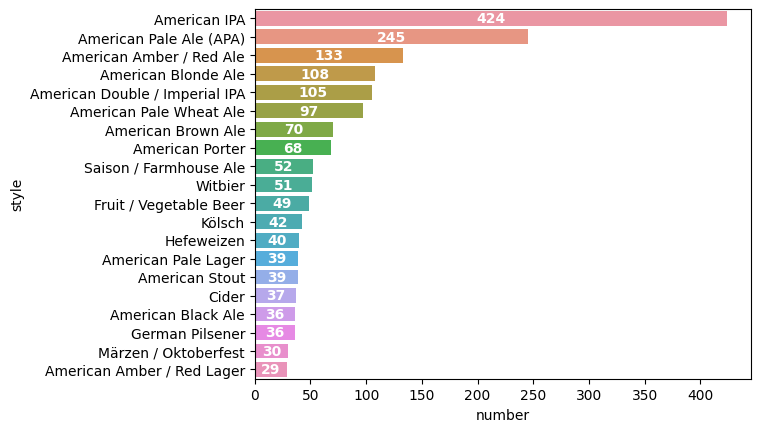

In [6]:
unique_beer = pd.read_sql_query("""
SELECT DISTINCT style, 
COUNT() OVER(PARTITION BY style) AS number
FROM beers
ORDER BY number DESC
LIMIT 20;
""", conn)

ax = sns.barplot(y='style', x='number', data=unique_beer)
ax.bar_label(ax.containers[0], label_type='center', color='white', weight='heavy');

***

### Finding American Pale Lagers that are above or equal to 0.055 abv


In [7]:
five_rows_beers = pd.read_sql_query("""
SELECT *
FROM beers
WHERE style IS 'American Pale Lager' AND abv >= 0.055
ORDER BY abv DESC;
""", conn)

five_rows_beers

,abv,ibu,id,name,style,brewery_id,ounces
0,0.072,75.0,2045,Might As Well IPL,American Pale Lager,240,16.0
1,0.068,62.0,2189,In-Tents India Pale Lager,American Pale Lager,116,12.0
2,0.067,NaN,1528,Orlison India Pale Lager,American Pale Lager,390,16.0
3,0.062,40.0,1894,Pt. Bonita Rustic Lager,American Pale Lager,280,16.0
4,0.062,NaN,2281,Clear Creek Ice,American Pale Lager,134,16.0
5,0.062,NaN,2280,Clear Creek Ice,American Pale Lager,134,12.0
6,0.060,NaN,1828,Hopsmith Pale Lager,American Pale Lager,301,16.0
7,0.055,NaN,110,BrewFarm Select Golden Lager,American Pale Lager,554,12.0
8,0.055,NaN,2279,Mountain Crest,American Pale Lager,134,16.0
9,0.055,NaN,2278,Mountain Crest,American Pale Lager,134,12.0


***

## ABV classification

As either low, medium, high in a new column
abv: The alcoholic content by volume with 0 being no alcohol and 1 being pure alcohol

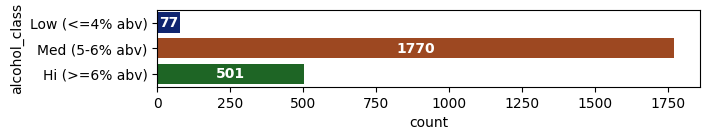

In [8]:
low_med_high_abv = pd.read_sql_query("""
SELECT COUNT(*) AS count, alcohol_class
FROM (
        SELECT
            CASE
                WHEN abv <= 0.04 THEN 'Low (<=4% abv)'
                WHEN abv >= 0.07 THEN 'Hi (>=6% abv)'
                ELSE 'Med (5-6% abv)'
            END AS alcohol_class
        FROM beers
        WHERE abv IS NOT NULL
) AS subquery
GROUP BY alcohol_class
ORDER BY count;
""", conn)

plt.figure(figsize=(7,1))
ax = sns.barplot(y='alcohol_class', 
            x='count', 
            data=low_med_high_abv, 
            order=(['Low (<=4% abv)', 'Med (5-6% abv)', 'Hi (>=6% abv)']));

ax.bar_label(ax.containers[0], label_type='center', color='white', weight='heavy');

***

### How many breweries have '*brewing company*' within their name

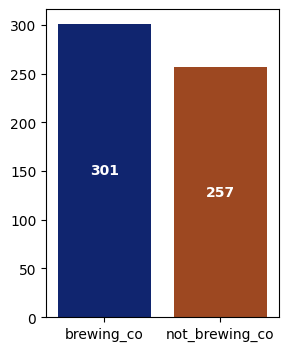

In [9]:
breweries = pd.read_sql_query("""
SELECT
    SUM(CASE WHEN name LIKE "%brewing company%" THEN 1 ELSE 0 END) AS brewing_co,
    SUM(CASE WHEN name NOT LIKE "%brewing company%" THEN 1 ELSE 0 END) AS not_brewing_co
FROM breweries;
""", conn)

plt.figure(figsize=(3,4))
ax = sns.barplot(data=breweries, width=0.8)

ax.bar_label(ax.containers[0], label_type='center', color='white', weight='heavy');

***

### Finding the number of breweries in each city

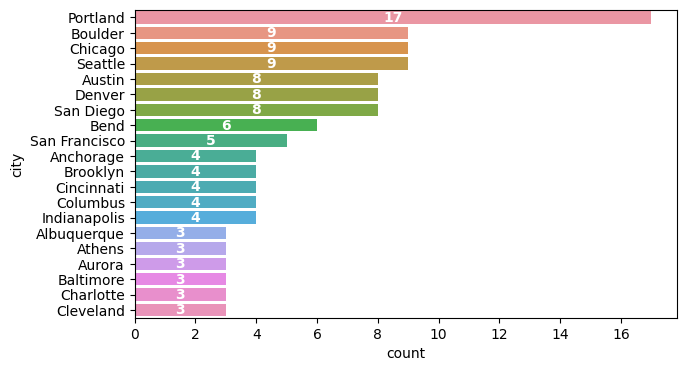

In [10]:
breweries = pd.read_sql_query("""
SELECT DISTINCT city,
COUNT() OVER(PARTITION BY city) AS count
FROM breweries
ORDER BY count DESC
LIMIT 20;
""", conn)

plt.figure(figsize=(7,4))
ax = sns.barplot(y='city', x='count', data=breweries)
ax.bar_label(ax.containers[0], label_type='center', color='white', weight='heavy');

***

### Retrieving first 10 rows of info from 'breweries': brewery_id, name, city, state


In [11]:
five_rows_breweries = pd.read_sql_query("""
SELECT brewery_id, name, city, state
FROM breweries
LIMIT 10;
""", conn)

five_rows_breweries

,brewery_id,name,city,state
0,0,NorthGate Brewing,Minneapolis,MN
1,1,Against the Grain Brewery,Louisville,KY
2,2,Jack's Abby Craft Lagers,Framingham,MA
3,3,Mike Hess Brewing Company,San Diego,CA
4,4,Fort Point Beer Company,San Francisco,CA
5,5,COAST Brewing Company,Charleston,SC
6,6,Great Divide Brewing Company,Denver,CO
7,7,Tapistry Brewing,Bridgman,MI
8,8,Big Lake Brewing,Holland,MI
9,9,The Mitten Brewing Company,Grand Rapids,MI


***

### Using an alias 'row_count' to find out the number of rows in 'beer':


In [12]:
beers_total_rows = pd.read_sql_query("""
SELECT COUNT(*) AS row_count
FROM beers;
""", conn)

beers_total_rows

,row_count
0,2410


***

### Finding the number of distinct styles of beer in the 'beers' table:


In [13]:
distinct_styles = pd.read_sql_query("""
SELECT COUNT(DISTINCT(style)) AS distinct_styles
FROM beers;
""", conn)

distinct_styles

,distinct_styles
0,99


***

### Finding the min, average, and max abvs in the beers table:

In [14]:
alcoholic_content = pd.read_sql_query("""
SELECT MIN(abv) AS min, AVG(abv) AS avg, MAX(abv) AS max
FROM beers;
""", conn)

alcoholic_content

,min,avg,max
0,0.001,0.059773,0.128


***

### Getting only the abv column from the beers table to create a Histogram:


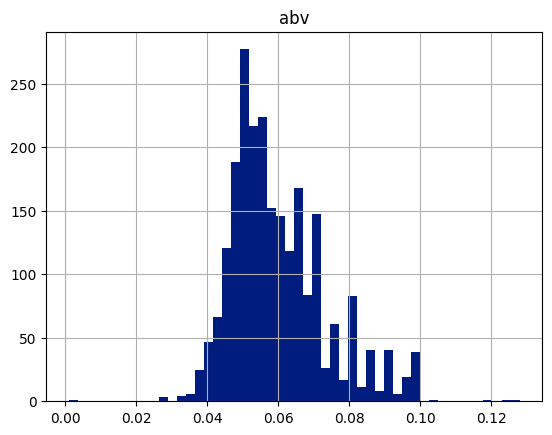

In [15]:
abv_distribution = pd.read_sql_query("""
SELECT abv
FROM beers;
""", conn)

abv_distribution.hist(bins=50);

***

### Finding the distinct ipa styles:


In [16]:
ipa_styles = pd.read_sql_query("""
SELECT DISTINCT(style) AS ipa_styles
FROM beers
WHERE style LIKE "%ipa%"
ORDER BY style ASC;
""", conn)

ipa_styles

,ipa_styles
0,American Double / Imperial IPA
1,American IPA
2,American White IPA
3,Belgian IPA
4,English India Pale Ale (IPA)


***

### Finding the average ibu for pale ales and lagers.


The `ibu` is an abbreviation for the International Bitterness Units scale; a measurement of a beer's bitterness. Calculate the average bitterness of lager beers and pale ale beers. A beer style lager contains `"lager"`, and a beer style is pale ale if its style contains `"IPA"`, `"APA"` or `"Pale Ale"`.

In [17]:
ale_bitterness = pd.read_sql_query("""
SELECT AVG(ibu)
FROM beers
WHERE style LIKE "%ipa%" OR style LIKE '%apa%' OR style LIKE '%pale ale%';
""", conn)

print(ale_bitterness)

lager_bitterness = pd.read_sql_query("""
SELECT AVG(ibu)
FROM beers
WHERE style LIKE "%lager%";
""", conn)

print(lager_bitterness)

    AVG(ibu)
0  63.353571
    AVG(ibu)
0  22.863636


***

### Inner joining two tables to find all the breweries and beers that can be found in San Francisco


In [18]:
beers_and_brewery = pd.read_sql_query("""
SELECT beers.name AS beer, breweries.name AS brewery 
FROM beers
INNER JOIN breweries
ON beers.brewery_id = breweries.brewery_id
WHERE breweries.city = 'San Francisco'
ORDER BY brewery ASC, beer ASC
LIMIT 10;
""", conn)

beers_and_brewery

,beer,brewery
0,21st Amendment IPA (2006),21st Amendment Brewery
1,21st Amendment Watermelon Wheat Beer (2006),21st Amendment Brewery
2,Back in Black,21st Amendment Brewery
3,Bitter American,21st Amendment Brewery
4,Bitter American (2011),21st Amendment Brewery
5,Brew Free! or Die IPA,21st Amendment Brewery
6,Brew Free! or Die IPA (2008),21st Amendment Brewery
7,Brew Free! or Die IPA (2009),21st Amendment Brewery
8,Fireside Chat,21st Amendment Brewery
9,Fireside Chat (2010),21st Amendment Brewery


***

### Querying both tables to find the largest breweries by number of beers produced:


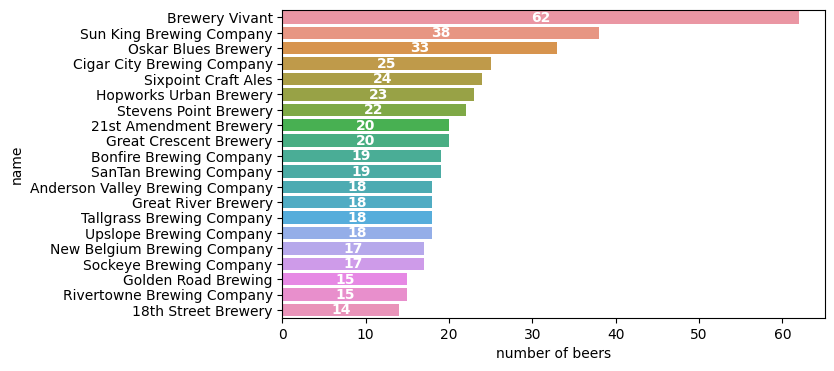

In [19]:
largest_breweries = pd.read_sql_query("""
SELECT breweries.name AS name, COUNT(*) AS "number of beers"
FROM beers
INNER JOIN breweries
ON beers.brewery_id = breweries.brewery_id
GROUP BY breweries.brewery_id, breweries.name 
ORDER BY "number of beers" DESC, name ASC
LIMIT 20;
""", conn)

plt.figure(figsize=(7,4))
ax = sns.barplot(y='name', x='number of beers', data=largest_breweries)
ax.bar_label(ax.containers[0], label_type='center', color='white', weight='heavy');

***

### Querying both tables to identify the top 10 US states with regard to the number of breweries and beers available:


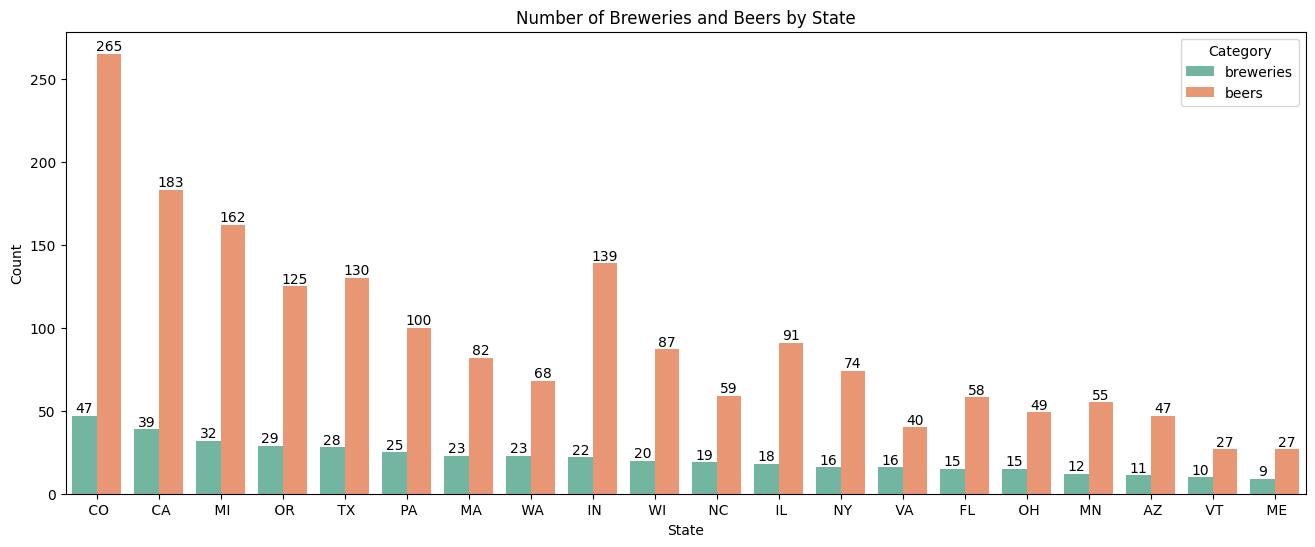

In [20]:
top_10_states = pd.read_sql_query("""
SELECT
    brew.state AS state
    , COUNT(DISTINCT(brew.brewery_id)) AS breweries
    , COUNT(*) AS beers
FROM beers
JOIN breweries AS brew
ON beers.brewery_id = brew.brewery_id
GROUP BY state
ORDER BY breweries DESC, state ASC
LIMIT 20
""", conn)

melted_df = top_10_states.melt(id_vars='state', var_name='category', value_name='count')

plt.figure(figsize=(16, 6))
ax = sns.barplot(data=melted_df, x='state', y='count', hue='category', palette='Set2')
plt.xlabel('State')
plt.ylabel('Count')
plt.title('Number of Breweries and Beers by State')
plt.legend(title='Category')
for container in ax.containers:
    ax.bar_label(container, label_type='edge', color='black')
plt.show();

***